In [108]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import functools
from scipy.stats import poisson

In [109]:
# Generate training data for sales probability regression
def generate_train_data(B=1000, T=100):

    def rank(a, p):
        return np.argsort(np.hstack((a, p)))[:,0]
    
    our_price = np.random.uniform(0, 20, (B, 1))
    competitor_prices = np.random.uniform(0, 20, (B, 5))
    our_rank = np.reshape(rank(our_price, competitor_prices), (B, 1))
    X = np.hstack((our_price, competitor_prices, our_rank))
    
    # Y = (our_rank == 0).astype(int).ravel()
    # Y = np.maximum(0, (3 - our_rank)).astype(int).ravel()
    Y = np.round(np.random.uniform(0, 1, our_rank.shape) * (1 - our_rank / 11)).ravel()
    
    return (X, Y)

X, Y = generate_train_data()

In [110]:
# Train sales probability model
def make_model(X, Y):
    regr = LogisticRegression()
    regr.fit(X, Y)
    def predict(x):
        return regr.predict_proba(x)[:, 1]
    return predict

sales_model = make_model(X, Y)

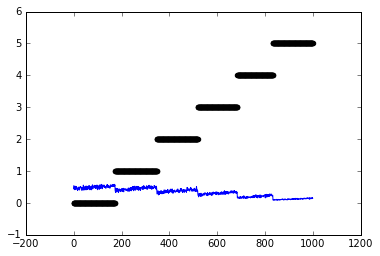

In [111]:
# Plot sales probability model
X_train, _ = generate_train_data(1000)
X_sort = np.sort(X_train.view('f8,f8,f8,f8,f8,f8,f8'), order=['f6'], axis=0).view(float)
plt.scatter(np.arange(0, X_sort.shape[0]), X_sort[:, 6], color='black')
plt.plot(np.arange(0, X_sort.shape[0]), sales_model(X_sort), color='blue', linewidth=1)

plt.show()

In [112]:
# Run Bellmann equation to calculate best price
def optimize_price(t, sales_model, competitor_prices,
               T=5, N=15, 
               price_range=np.arange(0.1, 20, 0.1), 
               L=0.01, delta=0.99, Z=0.5):

    def rank(a, p):
        order = np.argsort(np.hstack((a, p)))
        ranks = np.argsort(order)
        return ranks[0]

    @functools.lru_cache(maxsize=None)
    def sales_prob(price):
        x = np.hstack((price, competitor_prices, rank(price, competitor_prices))).reshape(1, -1)
        return sales_model(x)[0]


    @functools.lru_cache(maxsize=None)
    def _V(price, t, n):
        p = sales_prob(price)
        def mapper(i):
            if i > n:
                return 0
            pi = p if i == 1 else 1 - p
            # pi = poisson.pmf(i, p)
            today_profit = min(n, i) * price
            holding_costs = n * L
            V_future, _ = V(t + 1, max(0, n - i))
            exp_future_profits = delta * V_future
            return pi * (today_profit - holding_costs + exp_future_profits)
        # i_range = range(0, int(poisson.ppf(0.9999, p)) + 1)
        i_range = [0, 1]
        return sum([mapper(i) for i in i_range])

    def V(t, n):
        if t >= T:
            return (n * Z, 0)
        if n <= 0:
            return (0, 0)

        V_values = np.zeros(price_range.shape)
        for i, price in enumerate(price_range):
            v = _V(price, t, n)
            V_values[i] = v 

        V_opt = np.max(V_values)
        price_opt = price_range[np.argmax(V_values)]
        return (price_opt, V_opt)
    
    return V(t, N)

optimize_price(0, sales_model, np.random.uniform(0, 20, 5))

(16.900000000000002, 21.394715842297551)

In [113]:
def simulation(sales_model, T=20, N=15):
    competitor_prices = np.random.uniform(0, 20, 5)
    n = N
    
    def rank(a, p):
        order = np.argsort(np.hstack((a, p)))
        ranks = np.argsort(order)
        return ranks[0]
    
    def sales_prob(price):
        x = np.hstack((price, competitor_prices, rank(price, competitor_prices))).reshape(1, -1)
        return sales_model(x)[0]
        
    for t in range(0, T):
        price, _ = optimize_price(t, sales_model, competitor_prices, N=n, T=T)
        pi = sales_prob(price)
        n = max(0, n - np.random.poisson(pi))
        print(t, n, price, pi, competitor_prices, rank(price, competitor_prices))
        competitor_prices = competitor_prices * np.random.uniform(0.8, 1.2, 5)
        
            
simulation(sales_model)

0 15 16.9 0.364636647938 [  5.85791699  11.75453283   0.72879756  19.3879325   16.99847497] 3
1 14 18.4 0.378931773149 [  4.95439619  13.60973079   0.64459785  18.41408412  18.60105825] 3
2 14 16.3 0.355606588754 [  4.90890102  12.75478207   0.6651805   21.47053628  16.30270175] 3
3 11 15.1 0.452505345143 [  5.33190047  15.19659194   0.53524592  24.00551551  18.14808747] 2
4 9 15.9 0.453388593346 [  5.25709696  15.99157766   0.5968029   25.75346327  17.58423607] 2
5 9 16.6 0.447393509051 [  4.3406852   18.60012934   0.54794183  26.59239926  16.62316433] 2
6 9 17.3 0.452496346151 [  4.96410828  21.93581007   0.47661708  26.92258777  17.34170049] 2
7 8 18.1 0.456485762095 [  4.85244547  25.46163719   0.4526646   25.32890436  18.14862866] 2
8 8 17.8 0.451704539762 [  4.18716891  26.81663723   0.51139183  30.07341304  17.86208476] 2
9 8 19.9 0.491359337739 [  3.85092071  22.53341943   0.43548742  27.59389914  21.30899717] 2
10 7 19.9 0.490479053282 [  4.06568124  26.76304732   0.41883622  